# LDPC optimization using Graph Neural Network

### LDPC encode and decode using Standard Belief Propagation(BP)

In [90]:
import numpy as np
from pyldpc import make_ldpc, encode, decode, get_message

n = 16  # codeword length
d_v = 2  # number of ones per column
d_c = 4  # number of ones per row
snr = 5  # signal-to-noise ratio (dB)

# Create LDPC matrices
H, G = make_ldpc(n, d_v, d_c, systematic=True, sparse=True)

# Random binary message
k = G.shape[1]
message = np.random.randint(2, size=k)

# Encode (and modulate to BPSK: 0 -> +1, 1 -> -1)
codeword = encode(G, message,1000)

# Calculate the noise standard deviation (sigma) from the SNR
sigma = np.sqrt(1 / (10**(snr / 10)))

# Create noise with the correct standard deviation and add it to the codeword
noise = np.random.normal(0, sigma, codeword.shape)
y = codeword + noise

# Decode
decoded = decode(H, y, snr,maxiter=30)

# Extract original message
message_hat = get_message(G, decoded)

# Print results
print("Original message: ", message)
print("Decoded message:  ", message_hat)
print("Messages are equal:", np.array_equal(message,message_hat))


Original message:  [1 1 1 0 0 1 1 1 0]
Decoded message:   [1 1 1 0 0 1 1 1 0]
Messages are equal: True


LDPC code: (96, 50)  rate ≈ 0.52
Running 500 frames per SNR point...



SNR Progress:   8%|████████                                                                                         | 1/12 [00:06<01:14,  6.75s/it]

SNR=-6 dB → BER=2.3956e-01, FER=1.0000e+00


SNR Progress:  17%|████████████████▏                                                                                | 2/12 [00:13<01:07,  6.76s/it]

SNR=-5 dB → BER=2.1520e-01, FER=1.0000e+00


SNR Progress:  25%|████████████████████████▎                                                                        | 3/12 [00:19<00:59,  6.61s/it]

SNR=-4 dB → BER=1.8028e-01, FER=1.0000e+00


SNR Progress:  33%|████████████████████████████████▎                                                                | 4/12 [00:26<00:52,  6.56s/it]

SNR=-3 dB → BER=1.3912e-01, FER=1.0000e+00


SNR Progress:  42%|████████████████████████████████████████▍                                                        | 5/12 [00:34<00:49,  7.10s/it]

SNR=-2 dB → BER=1.0164e-01, FER=9.5400e-01


SNR Progress:  50%|████████████████████████████████████████████████▌                                                | 6/12 [00:39<00:39,  6.54s/it]

SNR=-1 dB → BER=4.3680e-02, FER=5.5400e-01


SNR Progress:  58%|████████████████████████████████████████████████████████▌                                        | 7/12 [00:41<00:25,  5.07s/it]

SNR= 0 dB → BER=6.3600e-03, FER=1.0400e-01


SNR Progress:  67%|████████████████████████████████████████████████████████████████▋                                | 8/12 [00:42<00:14,  3.69s/it]

SNR= 1 dB → BER=8.0000e-04, FER=2.8000e-02


SNR Progress:  75%|████████████████████████████████████████████████████████████████████████▊                        | 9/12 [00:43<00:08,  2.72s/it]

SNR= 2 dB → BER=2.0000e-04, FER=4.0000e-03


SNR Progress:  83%|████████████████████████████████████████████████████████████████████████████████                | 10/12 [00:43<00:03,  2.00s/it]

SNR= 3 dB → BER=2.4000e-04, FER=2.0000e-03


SNR Progress:  92%|████████████████████████████████████████████████████████████████████████████████████████        | 11/12 [00:44<00:01,  1.50s/it]

SNR= 4 dB → BER=4.0000e-05, FER=2.0000e-03


SNR Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:44<00:00,  3.70s/it]

SNR= 5 dB → BER=0.0000e+00, FER=0.0000e+00


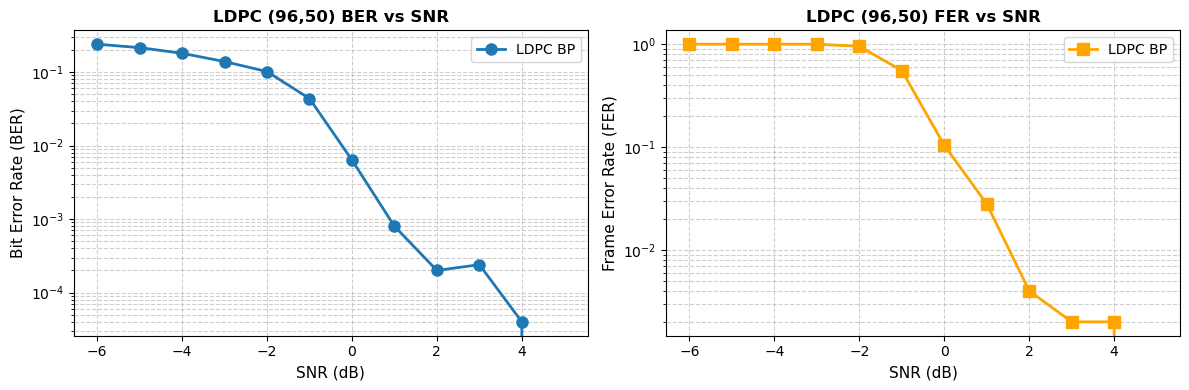

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pyldpc
from tqdm import tqdm

n, d_v, d_c = 96, 3, 6
H, G = pyldpc.make_ldpc(n, d_v, d_c, systematic=True, sparse=True)
k = G.shape[1]

snr_db_range = np.arange(-6, 6, 1)                                     # variables :- SNR range, code rate, max iter
Nframes = 500
max_iter = 30

print(f"LDPC code: ({n}, {k})  rate ≈ {k/n:.2f}")
print(f"Running {Nframes} frames per SNR point...\n")

BER = []
FER = []  

for snr_db in tqdm(snr_db_range, desc="SNR Progress"):
    total_err = 0
    frame_errors = 0
    
    for _ in range(Nframes):
        msg = np.random.randint(0, 2, size=k)                           # Generate random message
        codeword = pyldpc.encode(G, msg, 1000)                          # Encode using LDPC (outputs BPSK: {-1, +1})
        
        snr_linear = 10 ** (snr_db / 10)                                # Add AWGN noise
        sigma = np.sqrt(1 / (2 * snr_linear))
        y = codeword + sigma * np.random.randn(n)
        
        decoded = pyldpc.decode(H, y, snr_db, maxiter=max_iter)         # Decode using BP
        
        errors = np.sum(msg != decoded[:k])
        total_err += errors
        if errors > 0:
            frame_errors += 1
    
    ber = total_err / (k * Nframes)
    fer = frame_errors / Nframes
    BER.append(ber)
    FER.append(fer)
    print(f"SNR={snr_db:2d} dB → BER={ber:.4e}, FER={fer:.4e}")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.semilogy(snr_db_range, BER, marker='o', linewidth=2, markersize=8, label='LDPC BP')
ax1.set_title(f"LDPC ({n},{k}) BER vs SNR", fontsize=12, fontweight='bold')
ax1.set_xlabel("SNR (dB)", fontsize=11)
ax1.set_ylabel("Bit Error Rate (BER)", fontsize=11)
ax1.grid(True, which='both', linestyle='--', alpha=0.6)
ax1.legend()

ax2.semilogy(snr_db_range, FER, marker='s', linewidth=2, markersize=8, 
             color='orange', label='LDPC BP')
ax2.set_title(f"LDPC ({n},{k}) FER vs SNR", fontsize=12, fontweight='bold')
ax2.set_xlabel("SNR (dB)", fontsize=11)
ax2.set_ylabel("Frame Error Rate (FER)", fontsize=11)
ax2.grid(True, which='both', linestyle='--', alpha=0.6)
ax2.legend()
plt.tight_layout()
plt.show()



### LDPC encode and decode using Normalize min-sum method

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [05:06<00:00, 43.73s/it]


          BER_BP  Iter_BP  BER_MS  Iter_MS
SNR (dB)                                  
-3        0.1350     30.0  0.1506    30.00
-2        0.1064     30.0  0.1288    30.00
-1        0.0534     30.0  0.1038    29.48
 0        0.0086     30.0  0.0608    26.97
 1        0.0020     30.0  0.0396    21.26
 2        0.0004     30.0  0.0188    15.77
 3        0.0000     30.0  0.0052     6.26


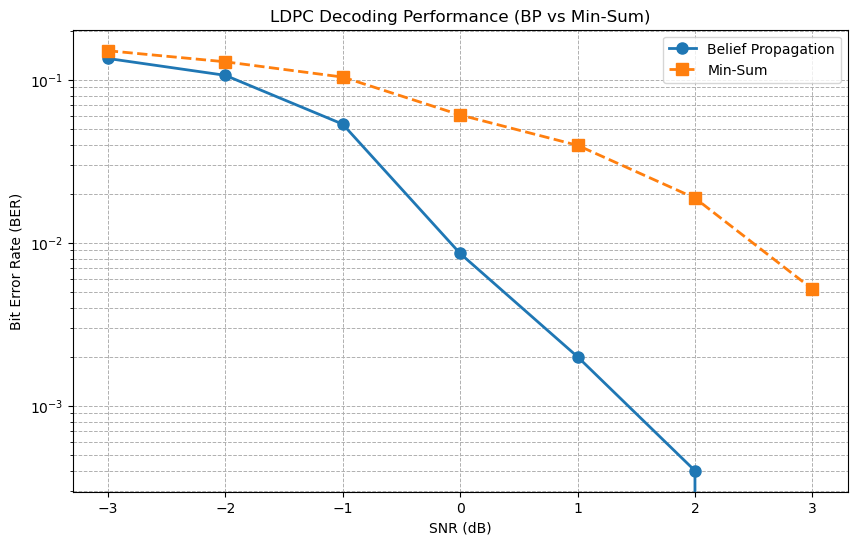

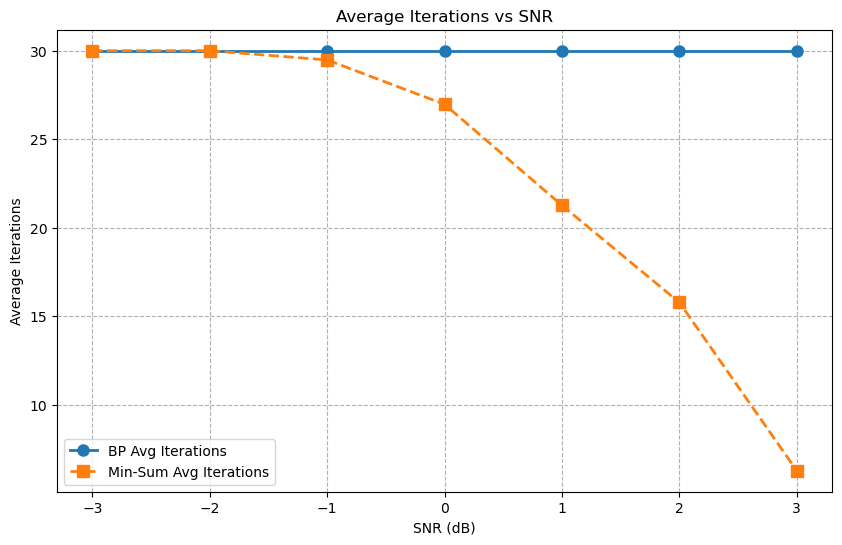

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyldpc
from tqdm import tqdm

n, d_v, d_c = 96, 3, 6
H, G = pyldpc.make_ldpc(n, d_v, d_c, systematic=True, sparse=True)
k = G.shape[1]  

snr_db_range = np.arange(-3, 4, 1)
Nframes = 100  
max_iter = 30

def awgn_channel(x, snr_db):
    snr_linear = 10 ** (snr_db / 10)
    sigma2 = 1 / (2 * snr_linear)
    noise = np.sqrt(sigma2) * np.random.randn(len(x))
    return x + noise, sigma2

# =====================================================================================
# ==================================Min-Sum Decoder====================================
def min_sum_decode(y, H, sigma2, max_iter=30,alpha=0.8):
    m, n = H.shape
    Lch = 2 * y / sigma2              # channel LLR
    Lq = np.tile(Lch, (m, 1))
    Lr = np.zeros((m, n))

    for it in range(max_iter):
        # Check node update
        for i in range(m):
            idx = np.where(H[i, :] == 1)[0]
            signs = np.sign(Lq[i, idx])
            mins = np.min(np.abs(Lq[i, idx]))
            for j_pos, j in enumerate(idx):
                sign_msg = np.prod(np.delete(signs, j_pos))
                Lr[i, j] = alpha * sign_msg * mins

        # Variable node update
        for j in range(n):
            idx = np.where(H[:, j] == 1)[0]
            Lq[idx, j] = Lch[j] + np.sum(Lr[idx, j]) - Lr[idx, j]

        # A-posteriori LLR
        L_post = Lch + np.sum(Lr, axis=0)
        hard = (L_post < 0).astype(int)

        # Early stopping if syndrome = 0
        if np.all((H @ hard) % 2 == 0):
            return hard, it + 1

    return hard, max_iter


ber_bp, ber_ms = [], []
iter_ms, iter_bp = [], []

for snr_db in tqdm(snr_db_range):
    err_bp = err_ms = 0
    it_ms_total = it_bp_total = 0
    bits_total = 0

    for _ in range(Nframes):
        msg = np.random.randint(2, size=k)
        codeword = pyldpc.encode(G, msg, snr=1000)                   # BPSK output (+1/-1)
        y, sigma2 = awgn_channel(codeword, snr_db)                   # AWGN channel
        
        decoded_bp = pyldpc.decode(H, y, snr_db, maxiter=max_iter)   # BP Decoding
        decoded_bp = decoded_bp[:k]  

        decoded_ms, it_used = min_sum_decode(y, H, sigma2, max_iter,alpha=0.8) # Min-Sum Decoding
        decoded_ms = decoded_ms[:k]

        err_bp += np.sum(decoded_bp != msg)
        err_ms += np.sum(decoded_ms != msg)
        bits_total += k
        it_ms_total += it_used
        it_bp_total += max_iter  

    ber_bp.append(err_bp / bits_total)
    ber_ms.append(err_ms / bits_total)
    iter_ms.append(it_ms_total / Nframes)
    iter_bp.append(it_bp_total / Nframes)

# print values
df = pd.DataFrame({
    'BER_BP': ber_bp,
    'Iter_BP': iter_bp,
    'BER_MS': ber_ms,
    'Iter_MS': iter_ms
}, index=snr_db_range)

df.index.name = 'SNR (dB)'
print(df)

plt.figure(figsize=(10, 6))
plt.semilogy(snr_db_range, ber_bp, 'o-', label='Belief Propagation', linewidth=2, markersize=8)
plt.semilogy(snr_db_range, ber_ms, 's--', label='Min-Sum', linewidth=2, markersize=8)
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('LDPC Decoding Performance (BP vs Min-Sum)')
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(snr_db_range, iter_bp, 'o-', label='BP Avg Iterations', linewidth=2, markersize=8)
plt.plot(snr_db_range, iter_ms, 's--', label='Min-Sum Avg Iterations', linewidth=2, markersize=8)
plt.xlabel('SNR (dB)')
plt.ylabel('Average Iterations')
plt.title('Average Iterations vs SNR')
plt.grid(True, linestyle='--')
plt.legend()
plt.show()


### Neural BP